In [1]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
import astropy
import gammapy
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs
gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator, LightCurveEstimator, ESTIMATOR_REGISTRY
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

print(MODEL_REGISTRY)

Registry
--------

SkyModel          : ['SkyModel', 'sky-model'] 
FoVBackgroundModel: ['FoVBackgroundModel', 'fov-bkg'] 
BackgroundModel   : BackgroundModel 

CPU times: user 2.56 s, sys: 1.24 s, total: 3.8 s
Wall time: 6.65 s


In [2]:
source = "RGBJ0710+591"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")
obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")
hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str41
43930,events,events,43930.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43930,gti,gti,43930.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43930,aeff,aeff_2d,43930.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43930,edisp,edisp_2d,43930.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43930,psf,psf_table,43930.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43930,bkg,bkg_2d,43930.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43931,events,events,43931.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43931,gti,gti,43931.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/RGBJ0710+591
43931,aeff,aeff_2d,43931.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/RGBJ0710+591


In [3]:
data_store.obs_table
data_store.hdu_table = hdu_table

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]



# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)
print(len(observations))


306


In [4]:
target_position = SkyCoord(ra="07h10m30.1017s",dec="+59d08m20.9639s", frame="icrs")
#print(target_position) -> In (107.62542375, 59.13915664)

on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)





In [38]:
energy_axis = MapAxis.from_energy_bounds(0.300, 20, 15, unit= "TeV", name="energy")


true_energy_axis = MapAxis.from_energy_bounds(0.100, 25, 20, unit= "TeV", name="energy_true")


geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", proj="CAR")
geom_image = geom.to_image()
# IS THERE AN EXCLUSION REGION ASIDE FROM THE CENTER???
center_region = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
exclusion_mask=Map.from_geom(geom_image)
exclusion_mask.data=geom_image.region_mask([center_region], inside=False)
#exclusion_mask.sum_over_axes().plot(add_cbar=True)

In [6]:
%time
e_reco = energy_axis
e_true = true_energy_axis
dataset_empty = SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region )
# Create the DatasetMaker
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "psf", "edisp"])
# Create the Background Maker
#help(ReflectedRegionsBackgroundMaker)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask, max_region_number=6)

#Create a Safe_mask_maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent = 10)



CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [7]:
%%time
# Create a stacked dataset
stacked = SpectrumDatasetOnOff.create(e_reco=e_reco,  e_true=e_true, region=on_region, name="RGBJ0710+591")
list_of_dataset = Datasets()
count = 0
for obs in observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    list_of_dataset.append(dataset)
    stacked.stack(dataset)
    count+=1
    print(dataset)
    print(count)
# Making sure all the datasets are in the list
print(count==len(observations))




SpectrumDatasetOnOff
--------------------

  Name                            : 43930 

  Total counts                    : 7 
  Total off counts                : 22.00
  Total background counts         : 3.67
  Total excess counts             : 3.33

  Predicted counts                : 4.14
  Predicted background counts     : 4.14
  Predicted excess counts         : nan

  Exposure min                    : 5.04e+00 m2 s
  Exposure max                    : 1.34e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


1
SpectrumDatasetOnOff
--------------------

  Name                            : 43931 

  Total counts                    : 4 
  Total off counts           

SpectrumDatasetOnOff
--------------------

  Name                            : 44363 

  Total counts                    : 4 
  Total off counts                : 22.00
  Total background counts         : 3.67
  Total excess counts             : 0.33

  Predicted counts                : 3.71
  Predicted background counts     : 3.71
  Predicted excess counts         : nan

  Exposure min                    : 9.99e+01 m2 s
  Exposure max                    : 1.30e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


11
SpectrumDatasetOnOff
--------------------

  Name                            : 44364 

  Total counts                    : 11 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 44446 

  Total counts                    : 4 
  Total off counts                : 17.00
  Total background counts         : 2.83
  Total excess counts             : 1.17

  Predicted counts                : 3.00
  Predicted background counts     : 3.00
  Predicted excess counts         : nan

  Exposure min                    : 8.15e+01 m2 s
  Exposure max                    : 1.12e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.58

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


21
SpectrumDatasetOnOff
--------------------

  Name                            : 44447 

  Total counts                    : 2 
  Total off counts          

SpectrumDatasetOnOff
--------------------

  Name                            : 44533 

  Total counts                    : 4 
  Total off counts                : 7.00
  Total background counts         : 1.17
  Total excess counts             : 2.83

  Predicted counts                : 1.57
  Predicted background counts     : 1.57
  Predicted excess counts         : nan

  Exposure min                    : 7.73e+02 m2 s
  Exposure max                    : 1.13e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


31
SpectrumDatasetOnOff
--------------------

  Name                            : 44534 

  Total counts                    : 4 
  Total off counts           

SpectrumDatasetOnOff
--------------------

  Name                            : 44570 

  Total counts                    : 5 
  Total off counts                : 13.00
  Total background counts         : 2.17
  Total excess counts             : 2.83

  Predicted counts                : 2.57
  Predicted background counts     : 2.57
  Predicted excess counts         : nan

  Exposure min                    : 5.70e+02 m2 s
  Exposure max                    : 1.18e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14.64

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


41
SpectrumDatasetOnOff
--------------------

  Name                            : 44571 

  Total counts                    : 3 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 44608 

  Total counts                    : 4 
  Total off counts                : 7.00
  Total background counts         : 1.17
  Total excess counts             : 2.83

  Predicted counts                : 1.57
  Predicted background counts     : 1.57
  Predicted excess counts         : nan

  Exposure min                    : 2.79e+02 m2 s
  Exposure max                    : 1.08e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.59

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


51
SpectrumDatasetOnOff
--------------------

  Name                            : 44633 

  Total counts                    : 2 
  Total off counts           

SpectrumDatasetOnOff
--------------------

  Name                            : 44688 

  Total counts                    : 6 
  Total off counts                : 19.00
  Total background counts         : 3.17
  Total excess counts             : 2.83

  Predicted counts                : 3.57
  Predicted background counts     : 3.57
  Predicted excess counts         : nan

  Exposure min                    : 4.31e+02 m2 s
  Exposure max                    : 1.08e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


61
SpectrumDatasetOnOff
--------------------

  Name                            : 44692 

  Total counts                    : 3 
  Total off counts          

SpectrumDatasetOnOff
--------------------

  Name                            : 44807 

  Total counts                    : 1 
  Total off counts                : 22.00
  Total background counts         : 3.67
  Total excess counts             : -2.67

  Predicted counts                : 3.29
  Predicted background counts     : 3.29
  Predicted excess counts         : nan

  Exposure min                    : 1.02e+03 m2 s
  Exposure max                    : 1.09e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.67

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


71
SpectrumDatasetOnOff
--------------------

  Name                            : 44808 

  Total counts                    : 7 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 48939 

  Total counts                    : 2 
  Total off counts                : 18.00
  Total background counts         : 3.00
  Total excess counts             : -1.00

  Predicted counts                : 2.86
  Predicted background counts     : 2.86
  Predicted excess counts         : nan

  Exposure min                    : 2.17e+02 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.49

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


81
SpectrumDatasetOnOff
--------------------

  Name                            : 49286 

  Total counts                    : 8 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 50228 

  Total counts                    : 2 
  Total off counts                : 19.00
  Total background counts         : 3.17
  Total excess counts             : -1.17

  Predicted counts                : 3.00
  Predicted background counts     : 3.00
  Predicted excess counts         : nan

  Exposure min                    : 1.24e+03 m2 s
  Exposure max                    : 1.69e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.12

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


91
SpectrumDatasetOnOff
--------------------

  Name                            : 50314 

  Total counts                    : 3 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 50804 

  Total counts                    : 3 
  Total off counts                : 15.00
  Total background counts         : 2.50
  Total excess counts             : 0.50

  Predicted counts                : 2.57
  Predicted background counts     : 2.57
  Predicted excess counts         : nan

  Exposure min                    : 1.09e+01 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


101
SpectrumDatasetOnOff
--------------------

  Name                            : 50831 

  Total counts                    : 2 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 53272 

  Total counts                    : 4 
  Total off counts                : 21.00
  Total background counts         : 3.50
  Total excess counts             : 0.50

  Predicted counts                : 3.57
  Predicted background counts     : 3.57
  Predicted excess counts         : nan

  Exposure min                    : 3.04e+02 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


111
SpectrumDatasetOnOff
--------------------

  Name                            : 53273 

  Total counts                    : 4 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 53868 

  Total counts                    : 7 
  Total off counts                : 14.00
  Total background counts         : 2.33
  Total excess counts             : 4.67

  Predicted counts                : 3.00
  Predicted background counts     : 3.00
  Predicted excess counts         : nan

  Exposure min                    : 3.97e+03 m2 s
  Exposure max                    : 1.79e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 19.87

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


121
SpectrumDatasetOnOff
--------------------

  Name                            : 54011 

  Total counts                    : 2 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 54408 

  Total counts                    : 4 
  Total off counts                : 8.00
  Total background counts         : 1.33
  Total excess counts             : 2.67

  Predicted counts                : 1.71
  Predicted background counts     : 1.71
  Predicted excess counts         : nan

  Exposure min                    : 1.16e+03 m2 s
  Exposure max                    : 1.69e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


131
SpectrumDatasetOnOff
--------------------

  Name                            : 54539 

  Total counts                    : 5 
  Total off counts          

SpectrumDatasetOnOff
--------------------

  Name                            : 55248 

  Total counts                    : 0 
  Total off counts                : 16.00
  Total background counts         : 2.67
  Total excess counts             : -2.67

  Predicted counts                : 2.29
  Predicted background counts     : 2.29
  Predicted excess counts         : nan

  Exposure min                    : 1.15e+04 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.93

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


141
SpectrumDatasetOnOff
--------------------

  Name                            : 55249 

  Total counts                    : 0 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 58974 

  Total counts                    : 3 
  Total off counts                : 16.00
  Total background counts         : 2.67
  Total excess counts             : 0.33

  Predicted counts                : 2.71
  Predicted background counts     : 2.71
  Predicted excess counts         : nan

  Exposure min                    : 6.22e+02 m2 s
  Exposure max                    : 1.75e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


151
SpectrumDatasetOnOff
--------------------

  Name                            : 59065 

  Total counts                    : 4 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 59808 

  Total counts                    : 2 
  Total off counts                : 7.00
  Total background counts         : 1.17
  Total excess counts             : 0.83

  Predicted counts                : 1.29
  Predicted background counts     : 1.29
  Predicted excess counts         : nan

  Exposure min                    : 6.33e+02 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


161
SpectrumDatasetOnOff
--------------------

  Name                            : 59809 

  Total counts                    : 3 
  Total off counts          

SpectrumDatasetOnOff
--------------------

  Name                            : 60163 

  Total counts                    : 1 
  Total off counts                : 12.00
  Total background counts         : 2.00
  Total excess counts             : -1.00

  Predicted counts                : 1.86
  Predicted background counts     : 1.86
  Predicted excess counts         : nan

  Exposure min                    : 9.49e+02 m2 s
  Exposure max                    : 1.68e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.18

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


171
SpectrumDatasetOnOff
--------------------

  Name                            : 60341 

  Total counts                    : 3 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 64365 

  Total counts                    : 9 
  Total off counts                : 23.00
  Total background counts         : 3.83
  Total excess counts             : 5.17

  Predicted counts                : 4.57
  Predicted background counts     : 4.57
  Predicted excess counts         : nan

  Exposure min                    : 1.04e+04 m2 s
  Exposure max                    : 1.96e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.22

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


181
SpectrumDatasetOnOff
--------------------

  Name                            : 64440 

  Total counts                    : 10 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 65050 

  Total counts                    : 1 
  Total off counts                : 35.00
  Total background counts         : 5.83
  Total excess counts             : -4.83

  Predicted counts                : 5.14
  Predicted background counts     : 5.14
  Predicted excess counts         : nan

  Exposure min                    : 3.08e+03 m2 s
  Exposure max                    : 3.66e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


191
SpectrumDatasetOnOff
--------------------

  Name                            : 65051 

  Total counts                    : 5 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 65785 

  Total counts                    : 5 
  Total off counts                : 14.00
  Total background counts         : 2.33
  Total excess counts             : 2.67

  Predicted counts                : 2.71
  Predicted background counts     : 2.71
  Predicted excess counts         : nan

  Exposure min                    : 7.06e+04 m2 s
  Exposure max                    : 1.97e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


201
SpectrumDatasetOnOff
--------------------

  Name                            : 65786 

  Total counts                    : 2 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 66177 

  Total counts                    : 3 
  Total off counts                : 21.00
  Total background counts         : 3.50
  Total excess counts             : -0.50

  Predicted counts                : 3.43
  Predicted background counts     : 3.43
  Predicted excess counts         : nan

  Exposure min                    : 1.13e+04 m2 s
  Exposure max                    : 1.92e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.89

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


211
SpectrumDatasetOnOff
--------------------

  Name                            : 66178 

  Total counts                    : 4 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 67048 

  Total counts                    : 6 
  Total off counts                : 22.00
  Total background counts         : 3.67
  Total excess counts             : 2.33

  Predicted counts                : 4.00
  Predicted background counts     : 4.00
  Predicted excess counts         : nan

  Exposure min                    : 1.10e+04 m2 s
  Exposure max                    : 1.80e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


221
SpectrumDatasetOnOff
--------------------

  Name                            : 67098 

  Total counts                    : 9 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 71378 

  Total counts                    : 9 
  Total off counts                : 45.00
  Total background counts         : 7.50
  Total excess counts             : 1.50

  Predicted counts                : 7.71
  Predicted background counts     : 7.71
  Predicted excess counts         : nan

  Exposure min                    : 9.51e+03 m2 s
  Exposure max                    : 2.78e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


231
SpectrumDatasetOnOff
--------------------

  Name                            : 71379 

  Total counts                    : 5 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 71853 

  Total counts                    : 2 
  Total off counts                : 35.00
  Total background counts         : 5.83
  Total excess counts             : -3.83

  Predicted counts                : 5.29
  Predicted background counts     : 5.29
  Predicted excess counts         : nan

  Exposure min                    : 7.43e+03 m2 s
  Exposure max                    : 2.81e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


241
SpectrumDatasetOnOff
--------------------

  Name                            : 72602 

  Total counts                    : 11 
  Total off counts       

SpectrumDatasetOnOff
--------------------

  Name                            : 76011 

  Total counts                    : 3 
  Total off counts                : 37.00
  Total background counts         : 6.17
  Total excess counts             : -3.17

  Predicted counts                : 5.71
  Predicted background counts     : 5.71
  Predicted excess counts         : nan

  Exposure min                    : 9.99e+03 m2 s
  Exposure max                    : 3.16e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.57

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


251
SpectrumDatasetOnOff
--------------------

  Name                            : 76013 

  Total counts                    : 5 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 76895 

  Total counts                    : 4 
  Total off counts                : 35.00
  Total background counts         : 5.83
  Total excess counts             : -1.83

  Predicted counts                : 5.57
  Predicted background counts     : 5.57
  Predicted excess counts         : nan

  Exposure min                    : 4.80e+02 m2 s
  Exposure max                    : 4.36e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


261
SpectrumDatasetOnOff
--------------------

  Name                            : 76896 

  Total counts                    : 2 
  Total off counts       

SpectrumDatasetOnOff
--------------------

  Name                            : 77301 

  Total counts                    : 5 
  Total off counts                : 27.00
  Total background counts         : 4.50
  Total excess counts             : 0.50

  Predicted counts                : 4.57
  Predicted background counts     : 4.57
  Predicted excess counts         : nan

  Exposure min                    : 8.93e+00 m2 s
  Exposure max                    : 5.16e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.05

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


271
SpectrumDatasetOnOff
--------------------

  Name                            : 77338 

  Total counts                    : 4 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 79754 

  Total counts                    : 5 
  Total off counts                : 29.00
  Total background counts         : 4.83
  Total excess counts             : 0.17

  Predicted counts                : 4.86
  Predicted background counts     : 4.86
  Predicted excess counts         : nan

  Exposure min                    : 4.25e+00 m2 s
  Exposure max                    : 6.94e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.71

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


281
SpectrumDatasetOnOff
--------------------

  Name                            : 79755 

  Total counts                    : 6 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 80208 

  Total counts                    : 6 
  Total off counts                : 24.00
  Total background counts         : 4.00
  Total excess counts             : 2.00

  Predicted counts                : 4.29
  Predicted background counts     : 4.29
  Predicted excess counts         : nan

  Exposure min                    : 3.79e+03 m2 s
  Exposure max                    : 2.70e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


291
SpectrumDatasetOnOff
--------------------

  Name                            : 80209 

  Total counts                    : 3 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 80633 

  Total counts                    : 5 
  Total off counts                : 23.00
  Total background counts         : 3.83
  Total excess counts             : 1.17

  Predicted counts                : 4.00
  Predicted background counts     : 4.00
  Predicted excess counts         : nan

  Exposure min                    : 1.58e+02 m2 s
  Exposure max                    : 4.77e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.23

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


301
SpectrumDatasetOnOff
--------------------

  Name                            : 80654 

  Total counts                    : 9 
  Total off counts         

In [8]:
stacked.info_dict()

{'name': 'RGBJ0710+591',
 'counts': 1342.0,
 'background': 1055.0001,
 'excess': 286.99988,
 'sqrt_ts': 7.7982650239954845,
 'npred': 1096.0001118243943,
 'npred_background': 1096.0001118243943,
 'npred_signal': nan,
 'exposure_min': <Quantity 1.3120019e+10 cm2 s>,
 'exposure_max': <Quantity 6.850061e+14 cm2 s>,
 'livetime': <Quantity 380206.46707347 s>,
 'ontime': <Quantity 427817.22028846 s>,
 'counts_rate': <Quantity 0.00352966 1 / s>,
 'background_rate': <Quantity 0.00277481 1 / s>,
 'excess_rate': <Quantity 0.00075485 1 / s>,
 'n_bins': 15,
 'n_fit_bins': 15,
 'stat_type': 'wstat',
 'stat_sum': 78.10782556791953,
 'counts_off': 6330.0,
 'acceptance': 15.0,
 'acceptance_off': 89.99999,
 'alpha': 0.1666667}

In [9]:
info_table= list_of_dataset.info_table(cumulative=False)
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
43930,7.0,3.6666666666666665,3.3333333333333335,1.4038603543438894,4.142857142857142,4.142857142857142,nan,5.0350458175357975,134077693.80371149,1083.745630876683,1202.4065105468035,0.006459080249613033,0.003383327749797303,0.00307575249981573,15,15,wstat,3.607330919145811,22.0,15.0,90.0,0.16666666666666663
43931,4.0,4.0,0.0,0.0,3.9999999999999996,3.9999999999999996,nan,21.939346964785656,122532913.10310487,1081.887186542908,1202.558512583375,0.0036972431596881275,0.0036972431596881275,0.0,15,15,wstat,3.0007373538407123,24.0,15.0,90.0,0.16666666666666663
43932,3.0,5.833333333333334,-2.833333333333334,-1.2147009423319894,5.428571428571429,5.428571428571429,nan,45.963434455886144,118566653.23986135,1080.6657381036925,1202.4837191849947,0.0027760665432627445,0.0053979071674553365,-0.0026218406241925924,15,15,wstat,9.33514438949372,35.0,15.0,89.99999999999999,0.16666666666666663
44017,1.0,4.333333333333333,-3.333333333333333,-1.831252266076784,3.8571428571428568,3.8571428571428568,nan,239.7317911987141,110461766.35908526,1081.2198797176789,1202.6880129873753,0.0009248812556619968,0.004007818774535319,-0.0030829375188733224,15,15,wstat,9.135066926888278,26.0,15.0,90.0,0.16666666666666663
44032,3.0,2.8333333333333326,0.1666666666666674,0.0906669521878775,2.8571428571428568,2.8571428571428568,nan,349.41792684813083,119393487.07055633,1087.2038633070051,1202.4655507802963,0.002759372093173715,0.0026060736435529522,0.0001532984496207626,15,15,wstat,4.025626405780546,17.0,15.0,90.00000000000003,0.16666666666666663
44033,2.0,3.333333333333333,-1.333333333333333,-0.7387012291482374,3.142857142857142,3.142857142857142,nan,140.09599920386822,96079703.39935553,825.3887435920856,914.0283586233854,0.002423100648666488,0.004038501081110812,-0.0016154004324443248,15,15,wstat,4.102260199439717,20.0,15.0,90.00000000000001,0.16666666666666663
44034,8.0,3.333333333333333,4.666666666666667,1.9487156327183668,3.999999999999999,3.999999999999999,nan,33.72982438190078,125614217.63690656,1088.5022053586708,1202.5407666414976,0.007349548729084964,0.003062311970452068,0.004287236758632896,15,15,wstat,7.623956658564083,20.0,15.0,90.00000000000001,0.16666666666666663
44059,4.0,3.0,1.0,0.5045551423570607,3.1428571428571423,3.1428571428571423,nan,1.6988003560049656,139416009.6398743,1099.9837435584616,1203.2378974705935,0.00363641737746046,0.002727313033095345,0.000909104344365115,15,15,wstat,4.378540525367485,18.0,15.0,90.0,0.16666666666666663


In [10]:
print(list_of_dataset[3])
obs.fixed_pointing_info.altaz
print(observations[3].fixed_pointing_info.altaz)
print(list_of_dataset[3].gti)

SpectrumDatasetOnOff
--------------------

  Name                            : 44017 

  Total counts                    : 1 
  Total off counts                : 26.00
  Total background counts         : 4.33
  Total excess counts             : -3.33

  Predicted counts                : 3.86
  Predicted background counts     : 3.86
  Predicted excess counts         : nan

  Exposure min                    : 2.40e+02 m2 s
  Exposure max                    : 1.10e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


<SkyCoord (AltAz: obstime=54847.278137560425, location=(-1943213.38858417, -5074839.41888431, 3330482.06737344) m, pressure=0.0 hPa, temperature=0.0 deg_C, 

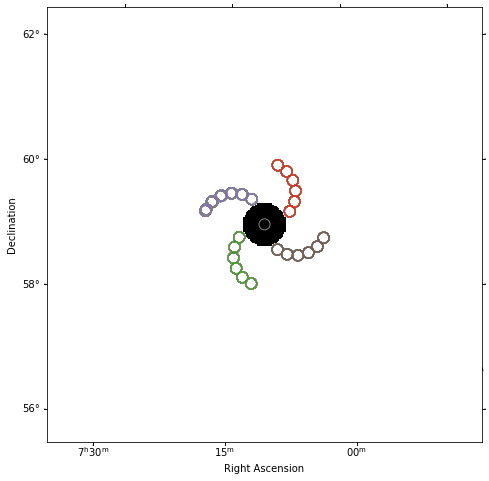

In [11]:
plt.figure(figsize=(8,8))
_, ax, _ = exclusion_mask.plot()

on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="grey")
plot_spectrum_datasets_off_regions(ax=ax, datasets=list_of_dataset)

In [ ]:
%%time
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.50, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = f"{source}")

joint_model = sky_model


for dataset in list_of_dataset:
    dataset.models = joint_model
    
    
# Performing a joint fit of the model:
joint_fit = Fit(list_of_dataset)
result_joint = joint_fit.run()
result_joint.parameters.to_table()

In [ ]:
total_stat = result_joint.total_stat

for par in dataset.models.parameters:
    if par.frozen is False:
        profile=joint_fit.stat_profile(parameter=par)
        plt.plot(profile[f"{par.name}_scan"], profile["stat_scan"]-total_stat)
        plt.xlabel(f"{par.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{par.name}: {par.value} +- {par.error}")
        plt.show()
        plt.close()

The stacked dataset

In [15]:
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.5, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = f"{source}")

stacked_model = sky_model
stacked.models = stacked_model
  
  
# Performing a joint fit of the model:
stacked_fit = Fit([stacked])
result_stacked = stacked_fit.run()
print(result_stacked)
result_stacked.parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 96
	total stat : 14.89



name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,3.3346e+00,,nan,nan,False,3.064e-01
amplitude,1.0730e-13,cm-2 s-1 TeV-1,nan,nan,False,2.406e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [ ]:
total_stat = result_stacked.total_stat

for p in stacked.models.parameters:
    if p.frozen is False:
        profile=stacked_fit.stat_profile(parameter=p)
        plt.plot(profile[f"{p.name}_scan"], profile["stat_scan"]-total_stat)
        plt.xlabel(f"{p.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{p.name}: {p.value} +- {p.error}")
        plt.show()
        plt.close()

Compare Stacked and Joint spectral fit

In [ ]:
def plot_spectrum(model, result, label, color, ax=None):
    spec = model.spectral_model
    energy_range =[0.30, 20]*u.TeV
    spec.plot(ax=ax, energy_range=energy_range, energy_power=0, label=label, color=color)
    spec.plot_error(ax=ax, energy_range=energy_range, energy_power=0, color=color)

In [ ]:
plot_spectrum(model=stacked_model, result=result_stacked, label="stacked", color="tab:blue")
plot_spectrum(model=joint_model, result=result_joint, label="joint", color="orange")
plt.legend()



In [13]:
%%time
# Defining the energy edges
energy_edges = np.linspace(0.30, 10, 7)*u.TeV
print(energy_edges)

# There are other parameters to FluxPointsEstimator, but I don't think that they matter a lot
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=source)

flux_points_joint = fpe.run(datasets=list_of_dataset)




[ 0.3         1.91666667  3.53333333  5.15        6.76666667  8.38333333
 10.        ] TeV


ValueError: 'RGBJ0710+591' is not in list

In [14]:
flux_points_joint.table

NameError: name 'flux_points_joint' is not defined

In [ ]:
plt.figure(figsize=(8,5))
# To define the upper_limits and lower_limits, you do
"""

flux_points_joint["is_ul"] = flux_points_joint.table["ts"]<4 #TS threshold of 4


"""
ax = flux_points_joint.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange")
flux_points_joint.to_sed_type("dnde").plot_ts_profiles(ax=ax);

In [ ]:
plt.figure(figsize=(8,8))
# Final Plot with the best-fit model, the flux points and residuals



"""
ax_spectrum = flux_points_joint.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Gammapy Data")
"""
# Below is the same thing as above, but with the dataset, you've got a bigger range of plot. Like the residuals plot next run box
flux_points_joint_dataset= FluxPointsDataset(data=flux_points_joint,models=joint_model)
ax_spectrum = flux_points_joint_dataset.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label="Gammapy Data");


# The Joint Fit
plot_spectrum(ax=ax_spectrum,model=joint_model , result=result_joint, label="joint", color="orange")


# For the ED DATA
#ax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

# # DEFINIE THE AXIS BOUNDARY WITH ax (not plt)
ax_spectrum.set_xlim([0.25, 20])
ax_spectrum.set_ylim([1e-25, 3e-10])
#plt.axis([0.30, 16, 1e-15, 1e-9])
plt.legend()



In [ ]:
flux_points_joint_dataset.plot_residuals();

In [28]:
# REPEAT FOR STACK
# Defining the energy edges
energy_edges = np.linspace(0.30, 20, 9)*u.TeV

# There are other parameters to FluxPointsEstimator, but I don't think that they matter a lot
flux_points = fpe.run(datasets=stacked)
flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)

In [ ]:
plt.figure(figsize=(8,5))
# To define the upper_limits and lower_limits, you do
"""

flux_points_stacked["is_ul"] = flux_points_stacked.table["ts"]<4 #TS threshold of 4


"""
ax = flux_points_stacked.plot(energy_power=2, flux_unit="TeV-1 cm-2 s-1", color="darkorange")
flux_points_stacked.to_sed_type("dnde").plot_ts_profiles(ax=ax);



[7.900710133194855, 1.3321469929480103, -0.42217008939326245, 1.1947935646733754, nan, -0.5552486436249514]


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


(0.3, 30)

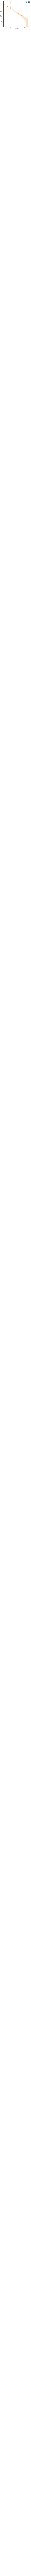

In [31]:

counts_list = list(flux_points.table["counts"])
sqrt_ts_list = list(flux_points.table["sqrt_ts"])
print(sqrt_ts_list)
plt.figure(figsize = (8, 8))
flux_points_stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked");
plt.legend()
plt.grid()
plt.ylim([1e-17, 1e-9])
count = 0

# For the ED DATA
#plt.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

for [x, y] in zip(flux_points.table["e_ref"], flux_points.table["dnde"]):
    label = f"{counts_list[count].sum()} counts, sig:{round(sqrt_ts_list[count].sum(), 2)}".format(y)
    count += 1
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,20), 
                 ha='center', rotation=90)
   
plt.legend()
plt.grid()
plt.ylim([1e-20, 1e-10])
plt.xlim([0, 30])

EXTRACTING THE LIGHT CURVE ESTIMATOR:

In [41]:
%%time
# RUN-BY-RUN

#Step1: Create the light curve maker using the LightCurveEstimator
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=True)

lc_1d = lc_maker_1d.run(list_of_dataset)




IndexError: list index out of range

In [36]:
lc_1d.table

NameError: name 'lc_1d' is not defined

In [ ]:
# GAMMAPY
plt.figure(figsize=(10,10))
ax = lc_1d.plot(marker="o", color="red", label="Gam Data")
plt.axhline(y=lc_1d.table["flux"].mean(), color="red", label="Mean Flux Line Gam")



In [ ]:
%%time
# NIGHT-BY-NIGHT 


# Step 1 is that we find the initial time and final time of the observations
# Step 2 is that we create the time_interval into separate night



if list_of_dataset[0].gti.time_start.value > list(lc_1d.table["time_min"])[0]:
    time_start = Time(list(lc_1d.table["time_min"])[0], format="mjd", scale="utc")
else:
    time_start = list_of_dataset[0].gti.time_start

time = float(time_start.value)


if list_of_dataset[-1].gti.time_stop.value > list(lc_1d.table["time_max"])[-1]:
    time_end = list_of_dataset[-1].gti.time_stop
else:
    time_end = Time(list(lc_1d.table["time_max"])[-1], format="mjd", scale="utc")


time_intervals = []
count = 0
while time < (float(time_end.value)+3):
    t_plus_one = time + 1
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    time = t_plus_one
    for i in range(count, len(observations), 1):
        count +=1
        if float(list_of_dataset[i].gti.time_start.value) > time:
            time = int(list_of_dataset[i].gti.time_start.value)
            count = i
            break



print(time_intervals)



In [ ]:
%%time
lc_maker_1d.time_intervals=time_intervals

nightwise1_lc = lc_maker_1d.run(list_of_dataset)

In [ ]:
ax = nightwise1_lc.plot(marker="o", label="1D", color="red")
plt.axhline(y=nightwise1_lc.table["flux"].mean(), color="red")

In [ ]:
flux_list = list(lc_1d.table["flux"])
time_min_list = list(lc_1d.table["time_min"])
time_max_list = list(lc_1d.table["time_max"])
max_value = max(flux_list)
index = flux_list.index(max_value)
time_start = time_min_list[index]

# Creating the time interval:
# We break it up into 8 min bins for a total duration of 240 min (30 bins). 
duration = 5 * u.min
n_time_bins = 7

time_list = Time(time_start, format="mjd", scale="utc")+np.arange(n_time_bins+1)*duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(time_list[:-1], time_list[1:])]

print(time_intervals)

filt_observations = observations.select_time(time_intervals)





In [ ]:
print(filt_observations)

In [123]:
list_dataset = Datasets()
for obs in filt_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset.models = Models(sky_model)
    list_dataset.append(dataset)
    print(dataset)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


SpectrumDatasetOnOff
--------------------

  Name                            : kCl37CTj 

  Total counts                    : 0 
  Total off counts                : 0.00
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.10
  Predicted background counts     : 0.00
  Predicted excess counts         : 0.10

  Exposure min                    : 4.30e+06 m2 s
  Exposure max                    : 2.95e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 260.000

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 0.20

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : RGBJ0710+591
    Datasets names            : None
    Spectral model type       : PowerLawSpect

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


SpectrumDatasetOnOff
--------------------

  Name                            : VhxQlF5w 

  Total counts                    : 0 
  Total off counts                : 0.00
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.10
  Predicted background counts     : 0.00
  Predicted excess counts         : 0.10

  Exposure min                    : 4.30e+06 m2 s
  Exposure max                    : 2.95e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 260.000

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 0.20

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : RGBJ0710+591
    Datasets names            : None
    Spectral model type       : PowerLawSpect

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


SpectrumDatasetOnOff
--------------------

  Name                            : d-z9KxUf 

  Total counts                    : 0 
  Total off counts                : 0.00
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.10
  Predicted background counts     : 0.00
  Predicted excess counts         : 0.10

  Exposure min                    : 4.30e+06 m2 s
  Exposure max                    : 2.95e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 260.000

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 0.20

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : RGBJ0710+591
    Datasets names            : None
    Spectral model type       : PowerLawSpect

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


SpectrumDatasetOnOff
--------------------

  Name                            : d7hFCI_A 

  Total counts                    : 0 
  Total off counts                : 0.00
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.08
  Predicted background counts     : 0.00
  Predicted excess counts         : 0.08

  Exposure min                    : 3.39e+06 m2 s
  Exposure max                    : 2.32e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 260.000

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 0.16

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : RGBJ0710+591
    Datasets names            : None
    Spectral model type       : PowerLawSpect

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


SpectrumDatasetOnOff
--------------------

  Name                            : tRElLlKY 

  Total counts                    : 0 
  Total off counts                : 0.00
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.08
  Predicted background counts     : 0.00
  Predicted excess counts         : 0.08

  Exposure min                    : 3.59e+06 m2 s
  Exposure max                    : 2.14e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 260.000

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 0.15

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : RGBJ0710+591
    Datasets names            : None
    Spectral model type       : PowerLawSpect

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


SpectrumDatasetOnOff
--------------------

  Name                            : mdX3x82- 

  Total counts                    : 0 
  Total off counts                : 0.00
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.10
  Predicted background counts     : 0.00
  Predicted excess counts         : 0.10

  Exposure min                    : 4.82e+06 m2 s
  Exposure max                    : 2.87e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 260.000

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 0.20

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : RGBJ0710+591
    Datasets names            : None
    Spectral model type       : PowerLawSpect

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


In [124]:
%%time
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], source = f"{source}", reoptimize=True)
lc_maker_1d.time_intervals = time_intervals
lc_day = lc_maker_1d.run(list_dataset)



CPU times: user 9.26 s, sys: 222 ms, total: 9.48 s
Wall time: 11.3 s


In [125]:
lc_day.table

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
54863.1897504013,54863.19322262353,0.0,2.449489742783178,0.3,19.999999999999996,4.401223022923909e-15,9.033330488307517e-13,4.445550144549712e-13,2.6407338137543447e-14,0.00019132635497953743,3.8083080454906546e-05,True,0.08553959730506543,-3.8083080454906546e-05,0.028121128052589484,0.38666143933106756,20.09587189569163,0.20000000000000004 .. 5.000000000000001,0.039809549979645587 .. 0.9952387494911398,nan,8.420699584280525e-19,8.844641405304753e-14,3.764788450306939e-16,1.237673562156482e-16,1.7017832288607906e-15,1.728314195653402e-16,1.8153265228447337e-11,7.72707452293395e-14,2.540274434030564e-14,3.4928405685622e-13
54863.19322262353,54863.19669484575,0.0,2.449489742783178,0.3,19.999999999999996,4.401223022923909e-15,9.033330488307517e-13,4.445550144549712e-13,2.6407338137543447e-14,0.00019132635497953743,3.8083080454906546e-05,True,0.08553959730506543,-3.8083080454906546e-05,0.028121128052589484,0.38666143933106756,20.09587189569163,0.20000000000000004 .. 5.000000000000001,0.039809549979645587 .. 0.9952387494911398,nan,8.420699584280525e-19,8.844641405304753e-14,3.764788450306939e-16,1.237673562156482e-16,1.7017832288607906e-15,1.728314195653402e-16,1.8153265228447337e-11,7.72707452293395e-14,2.540274434030564e-14,3.4928405685622e-13
54863.19669484575,54863.200167067975,0.0,2.449489742783178,0.3,19.999999999999996,4.401223022923909e-15,9.033330488307517e-13,4.445550144549712e-13,2.6407338137543447e-14,0.00019132635497953743,3.8083080454906546e-05,True,0.08553959730506543,-3.8083080454906546e-05,0.028121128052589484,0.38666143933106756,20.09587189569163,0.20000000000000004 .. 5.000000000000001,0.039809549979645587 .. 0.9952387494911398,nan,8.420699584280525e-19,8.844641405304753e-14,3.764788450306939e-16,1.237673562156482e-16,1.7017832288607906e-15,1.728314195653402e-16,1.8153265228447337e-11,7.72707452293395e-14,2.540274434030564e-14,3.4928405685622e-13
54863.200167067975,54863.203639290194,0.0,2.449489742783178,0.3,19.999999999999996,4.401223022923909e-15,9.033330488307517e-13,4.445550144549712e-13,2.6407338137543447e-14,-4.3655745685100555e-11,8.907818066244248e-11,False,0.30168776140055775,-8.907818066244248e-11,0.01657053654344054,0.01657053654344054,25.484341494110822,0.20000000000000004 .. 5.000000000000001,0.03139182545496372 .. 0.7847956363740927,nan,-1.9213867299217563e-25,1.1216227050793563e-13,1.3277951212105097e-15,7.293062693719247e-17,7.293062693719247e-17,-3.943567784870182e-23,2.3020847899319162e-11,2.725245253008902e-13,1.4968713296547528e-14,1.4968713296547528e-14
54863.203639290194,54863.20711151241,0.0,2.449489742783178,0.3,19.999999999999996,4.401223022923909e-15,9.033330488307517e-13,4.445550144549712e-13,2.6407338137543447e-14,-4.3655745685100555e-11,8.51338532976778e-11,False,0.3085973670191378,-8.51338532976778e-11,0.017143060227681417,0.017143060227681417,26.66505376816376,0.20000000000000004 .. 5.000000000000001,0.030001814621209273 .. 0.7500453655302319,nan,-1.9213867299217563e-25,1.1735884855194626e-13,1.3582058365383287e-15,7.545043135744264e-17,7.545043135744264e-17,-3.943567784870182e-23,2.4087424317631294e-11,2.7876620041054024e-13,1.5485892861760655e-14,1.54

No handles with labels found to put in legend.


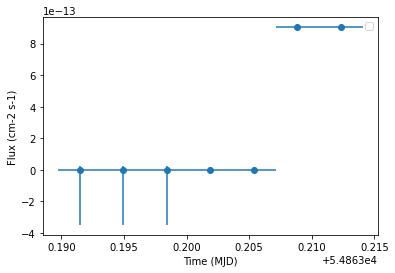

In [126]:
lc_day.plot(marker="o")

In [127]:
# 4 weeks:
if list_of_dataset[0].gti.time_start.value > list(lc_1d.table["time_min"])[0]:
    time_start = Time(list(lc_1d.table["time_min"])[0], format="mjd", scale="utc")
else:
    time_start = list_of_dataset[0].gti.time_start

time = float(time_start.value)


if list_of_dataset[-1].gti.time_stop.value > list(lc_1d.table["time_max"])[-1]:
    time_end = list_of_dataset[-1].gti.time_stop
else:
    time_end = Time(list(lc_1d.table["time_max"])[-1], format="mjd", scale="utc")


time_intervals = []
count = 0
while time < (float(time_end.value)+3):
    t_plus_one = time + 28
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    time = t_plus_one
    for i in range(count, len(observations), 1):
        count +=1
        if float(list_of_dataset[i].gti.time_start.value) > time:
            time = int(list_of_dataset[i].gti.time_start.value)
            count = i
            break



print(time_intervals)

[<Time object: scale='utc' format='mjd' value=[54834.23083483 54862.23083483]>, <Time object: scale='utc' format='mjd' value=[54863. 54891.]>, <Time object: scale='utc' format='mjd' value=[54891. 54919.]>, <Time object: scale='utc' format='mjd' value=[55159. 55187.]>, <Time object: scale='utc' format='mjd' value=[55202. 55230.]>, <Time object: scale='utc' format='mjd' value=[55245. 55273.]>, <Time object: scale='utc' format='mjd' value=[55273. 55301.]>, <Time object: scale='utc' format='mjd' value=[55301. 55329.]>, <Time object: scale='utc' format='mjd' value=[55504. 55532.]>, <Time object: scale='utc' format='mjd' value=[55535. 55563.]>, <Time object: scale='utc' format='mjd' value=[55564. 55592.]>, <Time object: scale='utc' format='mjd' value=[55594. 55622.]>, <Time object: scale='utc' format='mjd' value=[55625. 55653.]>, <Time object: scale='utc' format='mjd' value=[55889. 55917.]>, <Time object: scale='utc' format='mjd' value=[55919. 55947.]>, <Time object: scale='utc' format='mjd'

In [128]:
%%time
lc_maker_1d.time_intervals=time_intervals

four_week_lc = lc_maker_1d.run(list_of_dataset)




CPU times: user 3min 58s, sys: 2.55 s, total: 4min 1s
Wall time: 4min 14s


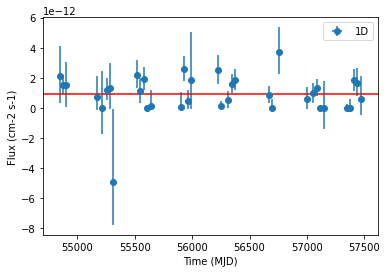

In [129]:
ax = four_week_lc.plot(marker="o", label="1D")
plt.axhline(y=four_week_lc.table["flux"].mean(), color="red")

In [130]:
four_week_lc.table

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
54834.231600845815,54862.231600845815,43.0,2.449489742783178,0.3,19.999999999999996,1.0095282885278319e-15,9.271995562670152e-13,3.93748351937331e-13,6.05716973116699e-15,2.2500502967304783,87.89488646237412,True,2.0330741769662826,1.4043123773160602,2.1506281661219875,1.9188090844642478,6.788065551177349,0.20000000000000004 .. 5.000000000000001,89.04577703494262 .. 89.48413891258102,1.185036867492341,2.27148942515986e-15,6.8527441982948024e-15,2.0524458943229018e-15,2.17111997180488e-15,1.937092051050848e-15,2.0862456367069655e-12,6.29389136696305e-12,1.8850654747410646e-12,1.9940614813236517e-12,1.7791189316763684e-12
54863.000766018515,54891.000766018515,192.0,2.449489742783178,0.3,19.999999999999996,1.0095282885278319e-15,9.271995562670152e-13,3.93748351937331e-13,6.05716973116699e-15,1.6416924197110347,400.0716320043833,True,0.653716926436467,6.551519196349091,0.6770762562397983,0.6360991505080987,3.0124303993678074,0.20000000000000004 .. 5.000000000000001,405.1063542802306 .. 421.50951465779957,2.5595935607727043,1.657334938759996e-15,3.041133705382996e-15,6.59945729927081e-16,6.835276341645953e-16,6.421600867464487e-16,1.522176483082994e-12,2.7931241295790987e-12,6.061260441161292e-13,6.277848043444729e-13,5.897908500929345e-13
54891.000766018515,54919.000766018515,38.0,2.449489742783178,0.3,19.999999999999996,1.0095282885278319e-15,9.271995562670152e-13,3.93748351937331e-13,6.05716973116699e-15,1.6033678105450235,62.08931623491614,True,1.5904844476235038,1.1389489522749159,1.6803936156410328,1.5075175574494788,5.1526509925915,0.20000000000000004 .. 5.000000000000001,62.949302090153985 .. 65.78371020540078,1.0672155135092987,1.6186451616601346e-15,5.201746937932132e-15,1.6056390423394899e-15,1.6964048908511872e-15,1.52188161969763e-15,1.4866419224701615e-12,4.7775357139296345e-12,1.4746964740861015e-12,1.558060214776291e-12,1.3977696103318913e-12
55159.000766018515,55187.000766018515,17.0,2.449489742783178,0.3,19.999999999999996,1.0095282885278319e-15,9.271995562670152e-13,3.93748351937331e-13,6.05716973116699e-15,0.7937723423237912,38.95574908143957,True,1.3630348494015987,0.37613899881890234,1.4729299739603354,0.9536889232047673,3.9168019859515777,0.20000000000000004 .. 5.000000000000001,39.1627016016214 .. 45.975557320846136,0.6133017192368715,8.013356342268653e-16,3.9541224053801095e-15,1.376022238720187e-15,1.4869644757335213e-15,9.627759464308596e-16,7.359853635796485e-13,3.631657063360067e-12,1.2638053075416403e-12,1.3657000182684094e-12,8.842599464122278e-13
55202.000766018515,55230.000766018515,10.0,2.449489742783178,0.3,19.999999999999996,1.0095282885278319e-15,9.271995562670152e-13,3.93748351937331e-13,6.05716973116699e-15,-0.0011670315288938582,11.742008533291113,True,0.23440487457700102,-8.231185589480106e-05,2.6183584774151116,1.9103318227626025,6.890518211290946,0.20000000000000004 .. 5.000000000000001,11.788655153152465 .. 14.246466237340435,nan,-1.1781513420222356e-18,6.956173056914406e-15,2.366383518543009e-16,2.6433069524572174e-15,1.9285340155537838e-15,-1.0820711157400017e-15,6.388885427958753e-12,2.173400956946207e-13,2.427740818407269e-12,1.7712588183882434e-12
55245.0